In [1]:
import os, gzip, requests
import numpy as np
import matplotlib.pyplot as plt


In [2]:
mnist_address = [
    "https://github.com/entropicemergence/tiny_llm_server/releases/download/v0.1.0/t10k-images-idx3-ubyte.gz",
    "https://github.com/entropicemergence/tiny_llm_server/releases/download/v0.1.0/t10k-labels-idx1-ubyte.gz",
    "https://github.com/entropicemergence/tiny_llm_server/releases/download/v0.1.0/train-images-idx3-ubyte.gz",
    "https://github.com/entropicemergence/tiny_llm_server/releases/download/v0.1.0/train-labels-idx1-ubyte.gz"
]

mnist_download_dir = "mnist"
os.makedirs(mnist_download_dir, exist_ok=True)
def download_mnist(url):
    for address in mnist_address:
        filename = address.split("/")[-1]
        filepath = os.path.join(mnist_download_dir, filename)
        if not os.path.exists(filepath):
            response = requests.get(address)
            with open(filepath, "wb") as f:
                f.write(response.content)
download_mnist(mnist_address)

(60000, 28, 28)
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136 175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253 225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251  93  82  82  56  39   0   0   0   0   0]
 [  0   0   0   0   0   0   0  18 219 253 253 253 253 253 198 18

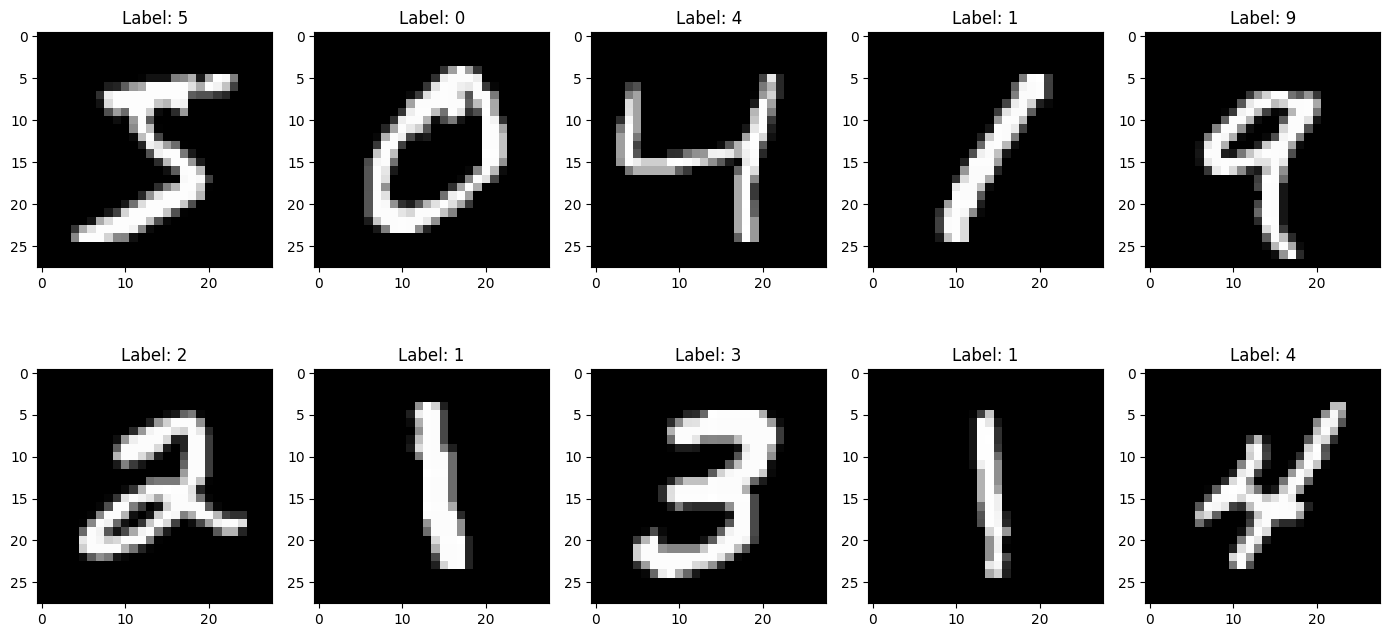

In [3]:
with gzip.open(("mnist/t10k-labels-idx1-ubyte.gz"), "rb") as f:
    test_labels = np.frombuffer(f.read(), np.uint8, offset=8)
with gzip.open(("mnist/t10k-images-idx3-ubyte.gz"), "rb") as f:
    test_images = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1, 28, 28)
with gzip.open(("mnist/train-labels-idx1-ubyte.gz"), "rb") as f:
    train_labels = np.frombuffer(f.read(), np.uint8, offset=8)
with gzip.open(("mnist/train-images-idx3-ubyte.gz"), "rb") as f:
    train_images = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1, 28, 28)

np.set_printoptions(linewidth=np.inf)
np.set_printoptions(threshold=np.inf)

print (train_images.shape)
print (train_images[0])
print (train_labels[0])

fig, ax = plt.subplots(2, 5, figsize=(14, 7))
for i in range(10):
    ax[i//5, i%5].imshow(train_images[i], cmap="gray")
    ax[i//5, i%5].set_title(f"Label: {train_labels[i]}")
    # ax[i//5, i%5].axis("off")
plt.tight_layout()
plt.show()

In [ ]:
train_images_scaled = (train_images / 255.0) - 0.5
# print (train_images_scaled[0])


scallar = 0.01
numpy_array = np.array([1, 2, 3, 4, 5])
print(scallar)
print (numpy_array)

numpy_matrix = np.array([[1, 2, 3], [4, 5, 6]])
print (numpy_matrix)




0.01
[1 2 3 4 5]
[[1 2 3]
 [4 5 6]]


In [ ]:
dbgksdfkv